In [ ]:
!pip install -q jax[tpu] flax optax transformers datasets diffusers torch torchvision -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

In [ ]:
!pip list -v | grep diffusers

In [ ]:
%%writefile /home/khang/.local/lib/python3.10/site-packages/diffusers/models/attention_flax.py

# Copyright 2025 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import functools
import math

import flax.linen as nn
import jax
import jax.numpy as jnp

from ..utils import logging


logger = logging.get_logger(__name__)


def _query_chunk_attention(query, key, value, precision, key_chunk_size: int = 4096):
    """Multi-head dot product attention with a limited number of queries."""
    num_kv, num_heads, k_features = key.shape[-3:]
    v_features = value.shape[-1]
    key_chunk_size = min(key_chunk_size, num_kv)
    query = query / jnp.sqrt(k_features)

    @functools.partial(jax.checkpoint, prevent_cse=False)
    def summarize_chunk(query, key, value):
        attn_weights = jnp.einsum("...qhd,...khd->...qhk", query, key, precision=precision)

        max_score = jnp.max(attn_weights, axis=-1, keepdims=True)
        max_score = jax.lax.stop_gradient(max_score)
        exp_weights = jnp.exp(attn_weights - max_score)

        exp_values = jnp.einsum("...vhf,...qhv->...qhf", value, exp_weights, precision=precision)
        max_score = jnp.einsum("...qhk->...qh", max_score)

        return (exp_values, exp_weights.sum(axis=-1), max_score)

    def chunk_scanner(chunk_idx):
        # julienne key array
        key_chunk = jax.lax.dynamic_slice(
            operand=key,
            start_indices=[0] * (key.ndim - 3) + [chunk_idx, 0, 0],  # [...,k,h,d]
            slice_sizes=list(key.shape[:-3]) + [key_chunk_size, num_heads, k_features],  # [...,k,h,d]
        )

        # julienne value array
        value_chunk = jax.lax.dynamic_slice(
            operand=value,
            start_indices=[0] * (value.ndim - 3) + [chunk_idx, 0, 0],  # [...,v,h,d]
            slice_sizes=list(value.shape[:-3]) + [key_chunk_size, num_heads, v_features],  # [...,v,h,d]
        )

        return summarize_chunk(query, key_chunk, value_chunk)

    chunk_values, chunk_weights, chunk_max = jax.lax.map(f=chunk_scanner, xs=jnp.arange(0, num_kv, key_chunk_size))

    global_max = jnp.max(chunk_max, axis=0, keepdims=True)
    max_diffs = jnp.exp(chunk_max - global_max)

    chunk_values *= jnp.expand_dims(max_diffs, axis=-1)
    chunk_weights *= max_diffs

    all_values = chunk_values.sum(axis=0)
    all_weights = jnp.expand_dims(chunk_weights, -1).sum(axis=0)

    return all_values / all_weights


def jax_memory_efficient_attention(
    query, key, value, precision=jax.lax.Precision.HIGHEST, query_chunk_size: int = 1024, key_chunk_size: int = 4096
):
    r"""
    Flax Memory-efficient multi-head dot product attention. https://huggingface.co/papers/2112.05682v2
    https://github.com/AminRezaei0x443/memory-efficient-attention

    Args:
        query (`jnp.ndarray`): (batch..., query_length, head, query_key_depth_per_head)
        key (`jnp.ndarray`): (batch..., key_value_length, head, query_key_depth_per_head)
        value (`jnp.ndarray`): (batch..., key_value_length, head, value_depth_per_head)
        precision (`jax.lax.Precision`, *optional*, defaults to `jax.lax.Precision.HIGHEST`):
            numerical precision for computation
        query_chunk_size (`int`, *optional*, defaults to 1024):
            chunk size to divide query array value must divide query_length equally without remainder
        key_chunk_size (`int`, *optional*, defaults to 4096):
            chunk size to divide key and value array value must divide key_value_length equally without remainder

    Returns:
        (`jnp.ndarray`) with shape of (batch..., query_length, head, value_depth_per_head)
    """
    num_q, num_heads, q_features = query.shape[-3:]

    def chunk_scanner(chunk_idx, _):
        # julienne query array
        query_chunk = jax.lax.dynamic_slice(
            operand=query,
            start_indices=([0] * (query.ndim - 3)) + [chunk_idx, 0, 0],  # [...,q,h,d]
            slice_sizes=list(query.shape[:-3]) + [min(query_chunk_size, num_q), num_heads, q_features],  # [...,q,h,d]
        )

        return (
            chunk_idx + query_chunk_size,  # unused ignore it
            _query_chunk_attention(
                query=query_chunk, key=key, value=value, precision=precision, key_chunk_size=key_chunk_size
            ),
        )

    _, res = jax.lax.scan(
        f=chunk_scanner,
        init=0,
        xs=None,
        length=math.ceil(num_q / query_chunk_size),  # start counter  # stop counter
    )

    return jnp.concatenate(res, axis=-3)  # fuse the chunked result back


class FlaxAttention(nn.Module):
    r"""
    A Flax multi-head attention module as described in: https://huggingface.co/papers/1706.03762

    Parameters:
        query_dim (:obj:`int`):
            Input hidden states dimension
        heads (:obj:`int`, *optional*, defaults to 8):
            Number of heads
        dim_head (:obj:`int`, *optional*, defaults to 64):
            Hidden states dimension inside each head
        dropout (:obj:`float`, *optional*, defaults to 0.0):
            Dropout rate
        use_memory_efficient_attention (`bool`, *optional*, defaults to `False`):
            enable memory efficient attention https://huggingface.co/papers/2112.05682
        split_head_dim (`bool`, *optional*, defaults to `False`):
            Whether to split the head dimension into a new axis for the self-attention computation. In most cases,
            enabling this flag should speed up the computation for Stable Diffusion 2.x and Stable Diffusion XL.
        dtype (:obj:`jnp.dtype`, *optional*, defaults to jnp.float32):
            Parameters `dtype`

    """

    query_dim: int
    heads: int = 8
    dim_head: int = 64
    dropout: float = 0.0
    use_memory_efficient_attention: bool = False
    split_head_dim: bool = False
    dtype: jnp.dtype = jnp.float32

    def setup(self):
        logger.warning(
            "Flax classes are deprecated and will be removed in Diffusers v1.0.0. We "
            "recommend migrating to PyTorch classes or pinning your version of Diffusers."
        )

        inner_dim = self.dim_head * self.heads
        self.scale = self.dim_head**-0.5

        # Weights were exported with old names {to_q, to_k, to_v, to_out}
        self.to_q = LoRADense(inner_dim)
        self.to_k = LoRADense(inner_dim)
        self.to_v = LoRADense(inner_dim)
        self.proj_attn = nn.Dense(self.query_dim, dtype=self.dtype, name="to_out_0")
        self.dropout_layer = nn.Dropout(rate=self.dropout)

    def reshape_heads_to_batch_dim(self, tensor):
        batch_size, seq_len, dim = tensor.shape
        head_size = self.heads
        tensor = tensor.reshape(batch_size, seq_len, head_size, dim // head_size)
        tensor = jnp.transpose(tensor, (0, 2, 1, 3))
        tensor = tensor.reshape(batch_size * head_size, seq_len, dim // head_size)
        return tensor

    def reshape_batch_dim_to_heads(self, tensor):
        batch_size, seq_len, dim = tensor.shape
        head_size = self.heads
        tensor = tensor.reshape(batch_size // head_size, head_size, seq_len, dim)
        tensor = jnp.transpose(tensor, (0, 2, 1, 3))
        tensor = tensor.reshape(batch_size // head_size, seq_len, dim * head_size)
        return tensor

    def __call__(self, hidden_states, context=None, deterministic=True):
        context = hidden_states if context is None else context

        query_proj = self.to_q(hidden_states)
        key_proj = self.to_k(context)
        value_proj = self.to_v(context)

        if self.split_head_dim:
            b = hidden_states.shape[0]
            query_states = jnp.reshape(query_proj, (b, -1, self.heads, self.dim_head))
            key_states = jnp.reshape(key_proj, (b, -1, self.heads, self.dim_head))
            value_states = jnp.reshape(value_proj, (b, -1, self.heads, self.dim_head))
        else:
            query_states = self.reshape_heads_to_batch_dim(query_proj)
            key_states = self.reshape_heads_to_batch_dim(key_proj)
            value_states = self.reshape_heads_to_batch_dim(value_proj)

        if self.use_memory_efficient_attention:
            query_states = query_states.transpose(1, 0, 2)
            key_states = key_states.transpose(1, 0, 2)
            value_states = value_states.transpose(1, 0, 2)

            # this if statement create a chunk size for each layer of the unet
            # the chunk size is equal to the query_length dimension of the deepest layer of the unet

            flatten_latent_dim = query_states.shape[-3]
            if flatten_latent_dim % 64 == 0:
                query_chunk_size = int(flatten_latent_dim / 64)
            elif flatten_latent_dim % 16 == 0:
                query_chunk_size = int(flatten_latent_dim / 16)
            elif flatten_latent_dim % 4 == 0:
                query_chunk_size = int(flatten_latent_dim / 4)
            else:
                query_chunk_size = int(flatten_latent_dim)

            hidden_states = jax_memory_efficient_attention(
                query_states, key_states, value_states, query_chunk_size=query_chunk_size, key_chunk_size=4096 * 4
            )
            hidden_states = hidden_states.transpose(1, 0, 2)
            hidden_states = self.reshape_batch_dim_to_heads(hidden_states)
        else:
            # compute attentions
            if self.split_head_dim:
                attention_scores = jnp.einsum("b t n h, b f n h -> b n f t", key_states, query_states)
            else:
                attention_scores = jnp.einsum("b i d, b j d->b i j", query_states, key_states)

            attention_scores = attention_scores * self.scale
            attention_probs = nn.softmax(attention_scores, axis=-1 if self.split_head_dim else 2)

            # attend to values
            if self.split_head_dim:
                hidden_states = jnp.einsum("b n f t, b t n h -> b f n h", attention_probs, value_states)
                b = hidden_states.shape[0]
                hidden_states = jnp.reshape(hidden_states, (b, -1, self.heads * self.dim_head))
            else:
                hidden_states = jnp.einsum("b i j, b j d -> b i d", attention_probs, value_states)
                hidden_states = self.reshape_batch_dim_to_heads(hidden_states)

        hidden_states = self.proj_attn(hidden_states)
        return self.dropout_layer(hidden_states, deterministic=deterministic)


class FlaxBasicTransformerBlock(nn.Module):
    r"""
    A Flax transformer block layer with `GLU` (Gated Linear Unit) activation function as described in:
    https://huggingface.co/papers/1706.03762


    Parameters:
        dim (:obj:`int`):
            Inner hidden states dimension
        n_heads (:obj:`int`):
            Number of heads
        d_head (:obj:`int`):
            Hidden states dimension inside each head
        dropout (:obj:`float`, *optional*, defaults to 0.0):
            Dropout rate
        only_cross_attention (`bool`, defaults to `False`):
            Whether to only apply cross attention.
        dtype (:obj:`jnp.dtype`, *optional*, defaults to jnp.float32):
            Parameters `dtype`
        use_memory_efficient_attention (`bool`, *optional*, defaults to `False`):
            enable memory efficient attention https://huggingface.co/papers/2112.05682
        split_head_dim (`bool`, *optional*, defaults to `False`):
            Whether to split the head dimension into a new axis for the self-attention computation. In most cases,
            enabling this flag should speed up the computation for Stable Diffusion 2.x and Stable Diffusion XL.
    """

    dim: int
    n_heads: int
    d_head: int
    dropout: float = 0.0
    only_cross_attention: bool = False
    dtype: jnp.dtype = jnp.float32
    use_memory_efficient_attention: bool = False
    split_head_dim: bool = False

    def setup(self):
        logger.warning(
            "Flax classes are deprecated and will be removed in Diffusers v1.0.0. We "
            "recommend migrating to PyTorch classes or pinning your version of Diffusers."
        )

        # self attention (or cross_attention if only_cross_attention is True)
        self.attn1 = FlaxAttention(
            self.dim,
            self.n_heads,
            self.d_head,
            self.dropout,
            self.use_memory_efficient_attention,
            self.split_head_dim,
            dtype=self.dtype,
        )
        # cross attention
        self.attn2 = FlaxAttention(
            self.dim,
            self.n_heads,
            self.d_head,
            self.dropout,
            self.use_memory_efficient_attention,
            self.split_head_dim,
            dtype=self.dtype,
        )
        self.ff = FlaxFeedForward(dim=self.dim, dropout=self.dropout, dtype=self.dtype)
        self.norm1 = nn.LayerNorm(epsilon=1e-5, dtype=self.dtype)
        self.norm2 = nn.LayerNorm(epsilon=1e-5, dtype=self.dtype)
        self.norm3 = nn.LayerNorm(epsilon=1e-5, dtype=self.dtype)
        self.dropout_layer = nn.Dropout(rate=self.dropout)

    def __call__(self, hidden_states, context, deterministic=True):
        # self attention
        residual = hidden_states
        if self.only_cross_attention:
            hidden_states = self.attn1(self.norm1(hidden_states), context, deterministic=deterministic)
        else:
            hidden_states = self.attn1(self.norm1(hidden_states), deterministic=deterministic)
        hidden_states = hidden_states + residual

        # cross attention
        residual = hidden_states
        hidden_states = self.attn2(self.norm2(hidden_states), context, deterministic=deterministic)
        hidden_states = hidden_states + residual

        # feed forward
        residual = hidden_states
        hidden_states = self.ff(self.norm3(hidden_states), deterministic=deterministic)
        hidden_states = hidden_states + residual

        return self.dropout_layer(hidden_states, deterministic=deterministic)


class FlaxTransformer2DModel(nn.Module):
    r"""
    A Spatial Transformer layer with Gated Linear Unit (GLU) activation function as described in:
    https://huggingface.co/papers/1506.02025


    Parameters:
        in_channels (:obj:`int`):
            Input number of channels
        n_heads (:obj:`int`):
            Number of heads
        d_head (:obj:`int`):
            Hidden states dimension inside each head
        depth (:obj:`int`, *optional*, defaults to 1):
            Number of transformers block
        dropout (:obj:`float`, *optional*, defaults to 0.0):
            Dropout rate
        use_linear_projection (`bool`, defaults to `False`): tbd
        only_cross_attention (`bool`, defaults to `False`): tbd
        dtype (:obj:`jnp.dtype`, *optional*, defaults to jnp.float32):
            Parameters `dtype`
        use_memory_efficient_attention (`bool`, *optional*, defaults to `False`):
            enable memory efficient attention https://huggingface.co/papers/2112.05682
        split_head_dim (`bool`, *optional*, defaults to `False`):
            Whether to split the head dimension into a new axis for the self-attention computation. In most cases,
            enabling this flag should speed up the computation for Stable Diffusion 2.x and Stable Diffusion XL.
    """

    in_channels: int
    n_heads: int
    d_head: int
    depth: int = 1
    dropout: float = 0.0
    use_linear_projection: bool = False
    only_cross_attention: bool = False
    dtype: jnp.dtype = jnp.float32
    use_memory_efficient_attention: bool = False
    split_head_dim: bool = False

    def setup(self):
        logger.warning(
            "Flax classes are deprecated and will be removed in Diffusers v1.0.0. We "
            "recommend migrating to PyTorch classes or pinning your version of Diffusers."
        )

        self.norm = nn.GroupNorm(num_groups=32, epsilon=1e-5)

        inner_dim = self.n_heads * self.d_head
        if self.use_linear_projection:
            self.proj_in = nn.Dense(inner_dim, dtype=self.dtype)
        else:
            self.proj_in = nn.Conv(
                inner_dim,
                kernel_size=(1, 1),
                strides=(1, 1),
                padding="VALID",
                dtype=self.dtype,
            )

        self.transformer_blocks = [
            FlaxBasicTransformerBlock(
                inner_dim,
                self.n_heads,
                self.d_head,
                dropout=self.dropout,
                only_cross_attention=self.only_cross_attention,
                dtype=self.dtype,
                use_memory_efficient_attention=self.use_memory_efficient_attention,
                split_head_dim=self.split_head_dim,
            )
            for _ in range(self.depth)
        ]

        if self.use_linear_projection:
            self.proj_out = nn.Dense(inner_dim, dtype=self.dtype)
        else:
            self.proj_out = nn.Conv(
                inner_dim,
                kernel_size=(1, 1),
                strides=(1, 1),
                padding="VALID",
                dtype=self.dtype,
            )

        self.dropout_layer = nn.Dropout(rate=self.dropout)

    def __call__(self, hidden_states, context, deterministic=True):
        batch, height, width, channels = hidden_states.shape
        residual = hidden_states
        hidden_states = self.norm(hidden_states)
        if self.use_linear_projection:
            hidden_states = hidden_states.reshape(batch, height * width, channels)
            hidden_states = self.proj_in(hidden_states)
        else:
            hidden_states = self.proj_in(hidden_states)
            hidden_states = hidden_states.reshape(batch, height * width, channels)

        for transformer_block in self.transformer_blocks:
            hidden_states = transformer_block(hidden_states, context, deterministic=deterministic)

        if self.use_linear_projection:
            hidden_states = self.proj_out(hidden_states)
            hidden_states = hidden_states.reshape(batch, height, width, channels)
        else:
            hidden_states = hidden_states.reshape(batch, height, width, channels)
            hidden_states = self.proj_out(hidden_states)

        hidden_states = hidden_states + residual
        return self.dropout_layer(hidden_states, deterministic=deterministic)


class FlaxFeedForward(nn.Module):
    r"""
    Flax module that encapsulates two Linear layers separated by a non-linearity. It is the counterpart of PyTorch's
    [`FeedForward`] class, with the following simplifications:
    - The activation function is currently hardcoded to a gated linear unit from:
    https://huggingface.co/papers/2002.05202
    - `dim_out` is equal to `dim`.
    - The number of hidden dimensions is hardcoded to `dim * 4` in [`FlaxGELU`].

    Parameters:
        dim (:obj:`int`):
            Inner hidden states dimension
        dropout (:obj:`float`, *optional*, defaults to 0.0):
            Dropout rate
        dtype (:obj:`jnp.dtype`, *optional*, defaults to jnp.float32):
            Parameters `dtype`
    """

    dim: int
    dropout: float = 0.0
    dtype: jnp.dtype = jnp.float32

    def setup(self):
        logger.warning(
            "Flax classes are deprecated and will be removed in Diffusers v1.0.0. We "
            "recommend migrating to PyTorch classes or pinning your version of Diffusers."
        )

        # The second linear layer needs to be called
        # net_2 for now to match the index of the Sequential layer
        self.net_0 = FlaxGEGLU(self.dim, self.dropout, self.dtype)
        self.net_2 = nn.Dense(self.dim, dtype=self.dtype)

    def __call__(self, hidden_states, deterministic=True):
        hidden_states = self.net_0(hidden_states, deterministic=deterministic)
        hidden_states = self.net_2(hidden_states)
        return hidden_states


class FlaxGEGLU(nn.Module):
    r"""
    Flax implementation of a Linear layer followed by the variant of the gated linear unit activation function from
    https://huggingface.co/papers/2002.05202.

    Parameters:
        dim (:obj:`int`):
            Input hidden states dimension
        dropout (:obj:`float`, *optional*, defaults to 0.0):
            Dropout rate
        dtype (:obj:`jnp.dtype`, *optional*, defaults to jnp.float32):
            Parameters `dtype`
    """

    dim: int
    dropout: float = 0.0
    dtype: jnp.dtype = jnp.float32

    def setup(self):
        logger.warning(
            "Flax classes are deprecated and will be removed in Diffusers v1.0.0. We "
            "recommend migrating to PyTorch classes or pinning your version of Diffusers."
        )

        inner_dim = self.dim * 4
        self.proj = nn.Dense(inner_dim * 2, dtype=self.dtype)
        self.dropout_layer = nn.Dropout(rate=self.dropout)

    def __call__(self, hidden_states, deterministic=True):
        hidden_states = self.proj(hidden_states)
        hidden_linear, hidden_gelu = jnp.split(hidden_states, 2, axis=2)
        return self.dropout_layer(hidden_linear * nn.gelu(hidden_gelu), deterministic=deterministic)


class LoRADense(nn.Module):
    inner_dim: int

    @nn.compact
    def __call__(self, inp):
        inner_dim = self.inner_dim
        kernel = self.param('kernel', nn.initializers.zeros, (inp.shape[-1], inner_dim))
        kernel1 = self.param('kernel1', nn.initializers.zeros, (inp.shape[-1], 64))
        kernel2 = self.param('kernel2', nn.initializers.zeros, (64, inner_dim))
        return jax.lax.stop_gradient(inp @ kernel) + inp @ kernel1 @ kernel2

In [6]:
%%writefile finetune_script.py
#!/usr/bin/env python
# coding=utf-8
# Copyright 2025 The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import argparse
import logging
import math
import os
import random
from pathlib import Path

import jax
import jax.numpy as jnp
import numpy as np
import optax
import torch
import torch.utils.checkpoint
import transformers
from datasets import load_dataset
from flax import jax_utils
from flax.training import train_state
from huggingface_hub import create_repo, upload_folder
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPImageProcessor, CLIPTokenizer, FlaxCLIPTextModel, set_seed

from diffusers import (
    FlaxAutoencoderKL,
    FlaxDDPMScheduler,
    FlaxPNDMScheduler,
    FlaxStableDiffusionPipeline,
    FlaxUNet2DConditionModel,
)
from diffusers.pipelines.stable_diffusion import FlaxStableDiffusionSafetyChecker
from diffusers.utils import check_min_version
from jax.sharding import PartitionSpec as P, Mesh, NamedSharding

# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
logger = logging.getLogger(__name__)

mesh = Mesh(np.array(jax.devices()).reshape((1, -1)), ('data', 'kernel',))
kernel_sharding = NamedSharding(mesh, P(None, 'kernel'))
conv_sharding = NamedSharding(mesh, P(None, None, None, 'kernel'))
sharding = NamedSharding(mesh, P('data'))
non_sharding = no_sharding = NamedSharding(mesh, P())

def parse_args():
    parser = argparse.ArgumentParser(description="Simple example of a training script.")
    parser.add_argument(
        "--pretrained_model_name_or_path",
        type=str,
        default=None,
        required=True,
        help="Path to pretrained model or model identifier from huggingface.co/models.",
    )
    parser.add_argument(
        "--revision",
        type=str,
        default=None,
        required=False,
        help="Revision of pretrained model identifier from huggingface.co/models.",
    )
    parser.add_argument(
        "--variant",
        type=str,
        default=None,
        help="Variant of the model files of the pretrained model identifier from huggingface.co/models, 'e.g.' fp16",
    )
    parser.add_argument(
        "--dataset_name",
        type=str,
        default=None,
        help=(
            "The name of the Dataset (from the HuggingFace hub) to train on (could be your own, possibly private,"
            " dataset). It can also be a path pointing to a local copy of a dataset in your filesystem,"
            " or to a folder containing files that 🤗 Datasets can understand."
        ),
    )
    parser.add_argument(
        "--dataset_config_name",
        type=str,
        default=None,
        help="The config of the Dataset, leave as None if there's only one config.",
    )
    parser.add_argument(
        "--train_data_dir",
        type=str,
        default=None,
        help=(
            "A folder containing the training data. Folder contents must follow the structure described in"
            " https://huggingface.co/docs/datasets/image_dataset#imagefolder. In particular, a `metadata.jsonl` file"
            " must exist to provide the captions for the images. Ignored if `dataset_name` is specified."
        ),
    )
    parser.add_argument(
        "--image_column", type=str, default="image", help="The column of the dataset containing an image."
    )
    parser.add_argument(
        "--caption_column",
        type=str,
        default="text",
        help="The column of the dataset containing a caption or a list of captions.",
    )
    parser.add_argument(
        "--max_train_samples",
        type=int,
        default=None,
        help=(
            "For debugging purposes or quicker training, truncate the number of training examples to this "
            "value if set."
        ),
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        default="sd-model-finetuned",
        help="The output directory where the model predictions and checkpoints will be written.",
    )
    parser.add_argument(
        "--cache_dir",
        type=str,
        default=None,
        help="The directory where the downloaded models and datasets will be stored.",
    )
    parser.add_argument("--seed", type=int, default=0, help="A seed for reproducible training.")
    parser.add_argument(
        "--resolution",
        type=int,
        default=512,
        help=(
            "The resolution for input images, all the images in the train/validation dataset will be resized to this"
            " resolution"
        ),
    )
    parser.add_argument(
        "--center_crop",
        default=False,
        action="store_true",
        help=(
            "Whether to center crop the input images to the resolution. If not set, the images will be randomly"
            " cropped. The images will be resized to the resolution first before cropping."
        ),
    )
    parser.add_argument(
        "--random_flip",
        action="store_true",
        help="whether to randomly flip images horizontally",
    )
    parser.add_argument(
        "--train_batch_size", type=int, default=16, help="Batch size (per device) for the training dataloader."
    )
    parser.add_argument("--num_train_epochs", type=int, default=100)
    parser.add_argument(
        "--max_train_steps",
        type=int,
        default=None,
        help="Total number of training steps to perform.  If provided, overrides num_train_epochs.",
    )
    parser.add_argument(
        "--learning_rate",
        type=float,
        default=1e-4,
        help="Initial learning rate (after the potential warmup period) to use.",
    )
    parser.add_argument(
        "--scale_lr",
        action="store_true",
        default=False,
        help="Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.",
    )
    parser.add_argument(
        "--lr_scheduler",
        type=str,
        default="constant",
        help=(
            'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
            ' "constant", "constant_with_warmup"]'
        ),
    )
    parser.add_argument("--adam_beta1", type=float, default=0.9, help="The beta1 parameter for the Adam optimizer.")
    parser.add_argument("--adam_beta2", type=float, default=0.999, help="The beta2 parameter for the Adam optimizer.")
    parser.add_argument("--adam_weight_decay", type=float, default=1e-2, help="Weight decay to use.")
    parser.add_argument("--adam_epsilon", type=float, default=1e-08, help="Epsilon value for the Adam optimizer")
    parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
    parser.add_argument("--push_to_hub", action="store_true", help="Whether or not to push the model to the Hub.")
    parser.add_argument("--hub_token", type=str, default=None, help="The token to use to push to the Model Hub.")
    parser.add_argument(
        "--hub_model_id",
        type=str,
        default=None,
        help="The name of the repository to keep in sync with the local `output_dir`.",
    )
    parser.add_argument(
        "--logging_dir",
        type=str,
        default="logs",
        help=(
            "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
            " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
        ),
    )
    parser.add_argument(
        "--report_to",
        type=str,
        default="tensorboard",
        help=(
            'The integration to report the results and logs to. Supported platforms are `"tensorboard"`'
            ' (default), `"wandb"` and `"comet_ml"`. Use `"all"` to report to all integrations.'
        ),
    )
    parser.add_argument(
        "--mixed_precision",
        type=str,
        default="no",
        choices=["no", "fp16", "bf16"],
        help=(
            "Whether to use mixed precision. Choose"
            "between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >= 1.10."
            "and an Nvidia Ampere GPU."
        ),
    )
    parser.add_argument("--local_rank", type=int, default=-1, help="For distributed training: local_rank")
    parser.add_argument(
        "--from_pt",
        action="store_true",
        default=False,
        help="Flag to indicate whether to convert models from PyTorch.",
    )

    args = parser.parse_args()
    env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
    if env_local_rank != -1 and env_local_rank != args.local_rank:
        args.local_rank = env_local_rank

    # Sanity checks
    if args.dataset_name is None and args.train_data_dir is None:
        raise ValueError("Need either a dataset name or a training folder.")

    return args


dataset_name_mapping = {
    "KhangTruong/NWPU_Split": ("image", "raw"),
}


def get_params_to_save(params):
    return jax.device_get(jax.tree_util.tree_map(lambda x: x[0], params))

def add_kernel_recursive(unet_weights, prefixes=('', 'attentions', 'transformer_blocks', 'attn', 'to_'), key=jax.random.key(0)):
    unet_weights = jax.tree.map(lambda x: x, unet_weights)
    if len(prefixes) == 0:
        key1, key2 = jax.random.split(key)
        unet_weights['kernel1'] = jax.random.normal(key1, (unet_weights['kernel'].shape[0], 64))
        unet_weights['kernel2'] = jax.random.normal(key2, (64, unet_weights['kernel'].shape[-1]))
        return unet_weights

    # assert any(k.startswith(prefixes[0]) for k in unet_weights.keys()), unet_weights.keys()

    for k in unet_weights.keys():
        key, subkey = jax.random.split(key)
        if k.startswith(prefixes[0]):
            unet_weights[k] = add_kernel_recursive(unet_weights[k], prefixes[1:], subkey)

    return unet_weights

def gradient_mask(grads):

    def mapper(path, x):
        addr = '/'.join(u.key for u in path)
        if 'kernel1' in addr or 'kernel2' in addr:
            return x
        else:
            return jnp.zeros_like(x)

    return jax.tree.map_with_path(mapper, grads)

def merge_kernel(unet_weights, extracted_kernels):
    unet_weights = jax.tree.map(lambda x: x, unet_weights)
    for path in extracted_kernels:
        node = unet_weights

        for k in path.split()[:-1]:
            node = node[k]
        val = extracted_kernels[path]
        assert type(node) is dict
        node[path.split()[-1]] = val
    return unet_weights

def extract_kernel(unet_weights):
    path_val, _ = jax.tree.flatten_with_path(unet_weights)
    path_val = [x for x in path_val if any(('kernel1' in u.key) or ('kernel2' in u.key) for u in x[0])]
    path_val = {' '.join(u.key for u in x[0]): x[1] for x in path_val}
    return path_val

def model_sharding(unet_weights):
    num_devices = jax.device_count()
    
    def mapper(path, x):
        addr = '/'.join(u.key for u in path)
        if ('kernel' in addr or 'kernel' in addr) and x.shape[-1] % num_devices == 0:
            if jnp.ndim(x) == 4:
                return jax.device_put(x, conv_sharding)
            elif jnp.ndim(x) == 2:
                return jax.device_put(x, kernel_sharding)
            else:
                return jax.device_put(x, non_sharding)
        else:
            return jax.device_put(x, non_sharding)

    return jax.tree.map_with_path(mapper, unet_weights)
    

def main():

    ds = load_dataset('KhangTruong/NWPU_Split').with_format('numpy')
    train_ds = ds['train']
    test_ds = ds['test']
    args = parse_args()

    if args.report_to == "wandb" and args.hub_token is not None:
        raise ValueError(
            "You cannot use both --report_to=wandb and --hub_token due to a security risk of exposing your token."
            " Please use `hf auth login` to authenticate with the Hub."
        )

    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )
    # Setup logging, we only want one process per machine to log things on the screen.
    logger.setLevel(logging.INFO if jax.process_index() == 0 else logging.ERROR)
    if jax.process_index() == 0:
        transformers.utils.logging.set_verbosity_info()
    else:
        transformers.utils.logging.set_verbosity_error()

    if args.seed is not None:
        set_seed(args.seed)

    # Handle the repository creation
    if jax.process_index() == 0:
        if args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)

        if args.push_to_hub:
            repo_id = create_repo(
                repo_id=args.hub_model_id or Path(args.output_dir).name, exist_ok=True, token=args.hub_token
            ).repo_id

    # Get the datasets: you can either provide your own training and evaluation files (see below)
    # or specify a Dataset from the hub (the dataset will be downloaded automatically from the datasets Hub).

    # In distributed training, the load_dataset function guarantees that only one local process can concurrently
    # download the dataset.
    if args.dataset_name is not None:
        # Downloading and loading a dataset from the hub.
        dataset = load_dataset(
            args.dataset_name, args.dataset_config_name, cache_dir=args.cache_dir, data_dir=args.train_data_dir
        )
    else:
        data_files = {}
        if args.train_data_dir is not None:
            data_files["train"] = os.path.join(args.train_data_dir, "**")
        dataset = load_dataset(
            "imagefolder",
            data_files=data_files,
            cache_dir=args.cache_dir,
        )
        # See more about loading custom images at
        # https://huggingface.co/docs/datasets/v2.4.0/en/image_load#imagefolder

    # Preprocessing the datasets.
    # We need to tokenize inputs and targets.
    column_names = dataset["train"].column_names

    # 6. Get the column names for input/target.
    dataset_columns = dataset_name_mapping.get(args.dataset_name, None)
    if args.image_column is None:
        image_column = dataset_columns[0] if dataset_columns is not None else column_names[0]
    else:
        image_column = args.image_column
        if image_column not in column_names:
            raise ValueError(
                f"--image_column' value '{args.image_column}' needs to be one of: {', '.join(column_names)}"
            )
    if args.caption_column is None:
        caption_column = dataset_columns[1] if dataset_columns is not None else column_names[1]
    else:
        caption_column = args.caption_column
        if caption_column not in column_names:
            raise ValueError(
                f"--caption_column' value '{args.caption_column}' needs to be one of: {', '.join(column_names)}"
            )

    # Preprocessing the datasets.
    # We need to tokenize input captions and transform the images.
    def tokenize_captions(examples, is_train=True):
        captions = []
        for caption in examples[caption_column]:
            if isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                # take a random caption if there are multiple
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should contain either strings or lists of strings."
                )
        inputs = tokenizer(captions, max_length=tokenizer.model_max_length, padding="do_not_pad", truncation=True)
        input_ids = inputs.input_ids
        return input_ids

    train_transforms = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
            transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples[image_column]]
        examples["pixel_values"] = [train_transforms(image) for image in images]
        examples["input_ids"] = tokenize_captions(examples)

        return examples

    if args.max_train_samples is not None:
        dataset["train"] = dataset["train"].shuffle(seed=args.seed).select(range(args.max_train_samples))
        # Set the training transforms
    train_dataset = dataset["train"].with_transform(preprocess_train)

    def collate_fn(examples):
        pixel_values = torch.stack([example["pixel_values"] for example in examples])
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
        input_ids = [example["input_ids"] for example in examples]

        padded_tokens = tokenizer.pad(
            {"input_ids": input_ids}, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt"
        )
        batch = {
            "pixel_values": pixel_values,
            "input_ids": padded_tokens.input_ids,
        }
        batch = {k: v.numpy() for k, v in batch.items()}

        return batch

    total_train_batch_size = args.train_batch_size * jax.local_device_count()
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, shuffle=True, collate_fn=collate_fn, batch_size=total_train_batch_size, drop_last=True
    )

    weight_dtype = jnp.float32
    if args.mixed_precision == "fp16":
        weight_dtype = jnp.float16
    elif args.mixed_precision == "bf16":
        weight_dtype = jnp.bfloat16

    # Load models and create wrapper for stable diffusion
    tokenizer = CLIPTokenizer.from_pretrained(
        args.pretrained_model_name_or_path,
        from_pt=args.from_pt,
        revision=args.revision,
        subfolder="tokenizer",
    )
    text_encoder = FlaxCLIPTextModel.from_pretrained(
        args.pretrained_model_name_or_path,
        from_pt=args.from_pt,
        revision=args.revision,
        subfolder="text_encoder",
        dtype=weight_dtype,
    )
    vae, vae_params = FlaxAutoencoderKL.from_pretrained(
        args.pretrained_model_name_or_path,
        from_pt=args.from_pt,
        revision=args.revision,
        subfolder="vae",
        dtype=weight_dtype,
    )
    unet, unet_params = FlaxUNet2DConditionModel.from_pretrained(
        args.pretrained_model_name_or_path,
        from_pt=args.from_pt,
        revision=args.revision,
        subfolder="unet",
        dtype=weight_dtype,
    )

    unet_params = model_sharding(unet_params)
    unet_clone = unet_params
    unet_params = add_kernel_recursive(unet_params)
    unet_params = model_sharding(unet_params)
    # Optimization
    if args.scale_lr:
        args.learning_rate = args.learning_rate * total_train_batch_size

    constant_scheduler = optax.constant_schedule(args.learning_rate)

    adamw = optax.adamw(
        learning_rate=constant_scheduler,
        b1=args.adam_beta1,
        b2=args.adam_beta2,
        eps=args.adam_epsilon,
        weight_decay=args.adam_weight_decay,
    )

    optimizer = optax.chain(
        optax.clip_by_global_norm(args.max_grad_norm),
        adamw,
    )

    state = train_state.TrainState.create(apply_fn=unet.__call__, params=unet_params, tx=optimizer)

    noise_scheduler = FlaxDDPMScheduler(
        beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000
    )
    noise_scheduler_state = noise_scheduler.create_state()

    # Initialize our training
    rng = jax.random.PRNGKey(args.seed)
    train_rngs = rng # jax.random.split(rng, jax.local_device_count())

    @jax.jit
    def train_step(state, text_encoder_params, vae_params, batch, train_rng):
        dropout_rng, sample_rng, new_train_rng = jax.random.split(train_rng, 3)

        def compute_loss(params):
            # Convert images to latent space
            vae_outputs = vae.apply(
                {"params": vae_params}, batch["pixel_values"], deterministic=True, method=vae.encode
            )
            latents = vae_outputs.latent_dist.sample(sample_rng)
            # (NHWC) -> (NCHW)
            latents = jnp.transpose(latents, (0, 3, 1, 2))
            latents = latents * vae.config.scaling_factor

            # Sample noise that we'll add to the latents
            noise_rng, timestep_rng = jax.random.split(sample_rng)
            noise = jax.random.normal(noise_rng, latents.shape)
            # Sample a random timestep for each image
            bsz = latents.shape[0]
            timesteps = jax.random.randint(
                timestep_rng,
                (bsz,),
                0,
                noise_scheduler.config.num_train_timesteps,
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(noise_scheduler_state, latents, noise, timesteps)

            # Get the text embedding for conditioning
            encoder_hidden_states = text_encoder(
                batch["input_ids"],
                params=text_encoder_params,
                train=False,
            )[0]

            # Predict the noise residual and compute loss
            model_pred = unet.apply(
                {"params": merge_kernel(state.params, params)}, noisy_latents, timesteps, encoder_hidden_states, train=True
            ).sample

            # Get the target for loss depending on the prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(noise_scheduler_state, latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            loss = (target - model_pred) ** 2
            loss = loss.mean()

            return loss

        grad_fn = jax.value_and_grad(compute_loss)
        loss, grad = grad_fn(extract_kernel(state.params))
        grad = merge_kernel(state.params, grad)
        grad = gradient_mask(grad)

        new_state = state.apply_gradients(grads=grad)

        metrics = {"loss": loss}
        print('Tracing train_step done.')
        return new_state, metrics, new_train_rng

    # Create parallel version of the train step
    p_train_step = train_step

    # Replicate the train state on each device
    state = jax.tree.map(lambda x: jax.device_put(x, no_sharding), state)
    text_encoder_params = jax.tree.map(lambda x: jax.device_put(x, no_sharding), text_encoder.params)
    vae_params = jax.tree.map(lambda x: jax.device_put(x, no_sharding), vae_params)

    # Train!
    num_update_steps_per_epoch = math.ceil(len(train_dataloader))

    # Scheduler and math around the number of training steps.
    if args.max_train_steps is None:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch

    args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Num Epochs = {args.num_train_epochs}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel & distributed) = {total_train_batch_size}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")

    global_step = 0

    epochs = tqdm(range(args.num_train_epochs), desc="Epoch ... ", position=0)
    for epoch in epochs:
        # ======================== Training ================================

        train_metrics = []

        steps_per_epoch = len(train_dataset) // total_train_batch_size
        train_step_progress_bar = tqdm(total=steps_per_epoch, desc="Training...", position=1, leave=False)
        # train
        for batch in train_dataloader:
            batch = jax.tree.map(lambda x: jax.device_put(x, sharding), batch)
            state, train_metric, train_rngs = p_train_step(state, text_encoder_params, vae_params, batch, train_rngs)
            train_metrics.append(train_metric)

            train_step_progress_bar.update(1)
            train_step_progress_bar.set_postfix({'loss': train_metric["loss"]})

            global_step += 1
            if global_step >= args.max_train_steps:
                break

        train_step_progress_bar.close()
        epochs.write(f"Epoch... ({epoch + 1}/{args.num_train_epochs} | Loss: {train_metric['loss']})")

    # Create the pipeline using using the trained modules and save it.
    if jax.process_index() == 0:
        scheduler = FlaxPNDMScheduler(
            beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
        )
        safety_checker = FlaxStableDiffusionSafetyChecker.from_pretrained(
            "CompVis/stable-diffusion-safety-checker", from_pt=True
        )
        pipeline = FlaxStableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=unet,
            tokenizer=tokenizer,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32"),
        )

        pipeline.save_pretrained(
            args.output_dir,
            params={
                "text_encoder": text_encoder_params,
                "vae": vae_params,
                "unet": state.params,
                "safety_checker": safety_checker.params,
            },
        )

        if args.push_to_hub:
            upload_folder(
                repo_id=repo_id,
                folder_path=args.output_dir,
                commit_message="End of training",
                ignore_patterns=["step_*", "epoch_*"],
            )


if __name__ == "__main__":
    main()

Overwriting finetune_script.py


In [1]:
MODEL_NAME="CompVis/stable-diffusion-v1-4"
dataset_name="KhangTruong/NWPU_Split"

!python finetune_script.py \
    --pretrained_model_name_or_path=$MODEL_NAME \
    --dataset_name=$dataset_name \
    --resolution=256 --center_crop --random_flip \
    --train_batch_size=8 \
    --num_train_epochs=1 \
    --max_train_steps=100 \
    --learning_rate=1e-05 \
    --max_grad_norm=1 \
    --revision="flax"\
    --output_dir="./sd-model-finetuned" \
    --caption_column="raw"

/home/khang/.local/lib/python3.10/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.INFO.20260101-033546.216146': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.INFO.20260101-033546.216146': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.INFO.20260101-033546.216146': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_

In [ ]:
!gsutil cp -r ./sd-model-finetuned/* gs://khang-sd-ft/lora

In [39]:
%%writefile ~/.local/lib/python3.11/site-packages/diffusers/pipelines/stable_diffusion/pipeline_flax_stable_diffusion.py 

# Copyright 2025 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import warnings
from functools import partial
from typing import Dict, List, Optional, Union

import jax
import jax.numpy as jnp
import numpy as np
from flax.core.frozen_dict import FrozenDict
from flax.jax_utils import unreplicate
from flax.training.common_utils import shard
from packaging import version
from PIL import Image
from transformers import CLIPImageProcessor, CLIPTokenizer, FlaxCLIPTextModel

from ...models import FlaxAutoencoderKL, FlaxUNet2DConditionModel
from ...schedulers import (
    FlaxDDIMScheduler,
    FlaxDPMSolverMultistepScheduler,
    FlaxLMSDiscreteScheduler,
    FlaxPNDMScheduler,
)
from ...utils import deprecate, logging, replace_example_docstring
from ..pipeline_flax_utils import FlaxDiffusionPipeline
from .pipeline_output import FlaxStableDiffusionPipelineOutput
from .safety_checker_flax import FlaxStableDiffusionSafetyChecker


logger = logging.get_logger(__name__)  # pylint: disable=invalid-name

# Set to True to use python for loop instead of jax.fori_loop for easier debugging
DEBUG = False

EXAMPLE_DOC_STRING = """
    Examples:
        ```py
        >>> import jax
        >>> import numpy as np
        >>> from flax.jax_utils import replicate
        >>> from flax.training.common_utils import shard

        >>> from diffusers import FlaxStableDiffusionPipeline

        >>> pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
        ...     "stable-diffusion-v1-5/stable-diffusion-v1-5", variant="bf16", dtype=jax.numpy.bfloat16
        ... )

        >>> prompt = "a photo of an astronaut riding a horse on mars"

        >>> prng_seed = jax.random.PRNGKey(0)
        >>> num_inference_steps = 50

        >>> num_samples = jax.device_count()
        >>> prompt = num_samples * [prompt]
        >>> prompt_ids = pipeline.prepare_inputs(prompt)
        # shard inputs and rng

        >>> params = replicate(params)
        >>> prng_seed = jax.random.split(prng_seed, jax.device_count())
        >>> prompt_ids = shard(prompt_ids)

        >>> images = pipeline(prompt_ids, params, prng_seed, num_inference_steps, jit=True).images
        >>> images = pipeline.numpy_to_pil(np.asarray(images.reshape((num_samples,) + images.shape[-3:])))
        ```
"""


class FlaxStableDiffusionPipeline(FlaxDiffusionPipeline):
    r"""
    Flax-based pipeline for text-to-image generation using Stable Diffusion.

    This model inherits from [`FlaxDiffusionPipeline`]. Check the superclass documentation for the generic methods
    implemented for all pipelines (downloading, saving, running on a particular device, etc.).

    Args:
        vae ([`FlaxAutoencoderKL`]):
            Variational Auto-Encoder (VAE) model to encode and decode images to and from latent representations.
        text_encoder ([`~transformers.FlaxCLIPTextModel`]):
            Frozen text-encoder ([clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14)).
        tokenizer ([`~transformers.CLIPTokenizer`]):
            A `CLIPTokenizer` to tokenize text.
        unet ([`FlaxUNet2DConditionModel`]):
            A `FlaxUNet2DConditionModel` to denoise the encoded image latents.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image latents. Can be one of
            [`FlaxDDIMScheduler`], [`FlaxLMSDiscreteScheduler`], [`FlaxPNDMScheduler`], or
            [`FlaxDPMSolverMultistepScheduler`].
        safety_checker ([`FlaxStableDiffusionSafetyChecker`]):
            Classification module that estimates whether generated images could be considered offensive or harmful.
            Please refer to the [model card](https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5) for
            more details about a model's potential harms.
        feature_extractor ([`~transformers.CLIPImageProcessor`]):
            A `CLIPImageProcessor` to extract features from generated images; used as inputs to the `safety_checker`.
    """

    def __init__(
        self,
        vae: FlaxAutoencoderKL,
        text_encoder: FlaxCLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: FlaxUNet2DConditionModel,
        scheduler: Union[
            FlaxDDIMScheduler, FlaxPNDMScheduler, FlaxLMSDiscreteScheduler, FlaxDPMSolverMultistepScheduler
        ],
        safety_checker: FlaxStableDiffusionSafetyChecker,
        feature_extractor: CLIPImageProcessor,
        dtype: jnp.dtype = jnp.float32,
    ):
        super().__init__()
        self.dtype = dtype

        if safety_checker is None:
            logger.warning(
                f"You have disabled the safety checker for {self.__class__} by passing `safety_checker=None`. Ensure"
                " that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered"
                " results in services or applications open to the public. Both the diffusers team and Hugging Face"
                " strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling"
                " it only for use-cases that involve analyzing network behavior or auditing its results. For more"
                " information, please have a look at https://github.com/huggingface/diffusers/pull/254 ."
            )

        is_unet_version_less_0_9_0 = (
            unet is not None
            and hasattr(unet.config, "_diffusers_version")
            and version.parse(version.parse(unet.config._diffusers_version).base_version) < version.parse("0.9.0.dev0")
        )
        is_unet_sample_size_less_64 = (
            unet is not None and hasattr(unet.config, "sample_size") and unet.config.sample_size < 64
        )
        if is_unet_version_less_0_9_0 and is_unet_sample_size_less_64:
            deprecation_message = (
                "The configuration file of the unet has set the default `sample_size` to smaller than"
                " 64 which seems highly unlikely .If you're checkpoint is a fine-tuned version of any of the"
                " following: \n- CompVis/stable-diffusion-v1-4 \n- CompVis/stable-diffusion-v1-3 \n-"
                " CompVis/stable-diffusion-v1-2 \n- CompVis/stable-diffusion-v1-1 \n- stable-diffusion-v1-5/stable-diffusion-v1-5"
                " \n- stable-diffusion-v1-5/stable-diffusion-inpainting \n you should change 'sample_size' to 64 in the"
                " configuration file. Please make sure to update the config accordingly as leaving `sample_size=32`"
                " in the config might lead to incorrect results in future versions. If you have downloaded this"
                " checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for"
                " the `unet/config.json` file"
            )
            deprecate("sample_size<64", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(unet.config)
            new_config["sample_size"] = 64
            unet._internal_dict = FrozenDict(new_config)

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )
        self.vae_scale_factor = 2 ** (len(self.vae.config.block_out_channels) - 1) if getattr(self, "vae", None) else 8

    def prepare_inputs(self, prompt: Union[str, List[str]]):
        if not isinstance(prompt, (str, list)):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        return text_input.input_ids

    def _get_has_nsfw_concepts(self, features, params):
        has_nsfw_concepts = self.safety_checker(features, params)
        return has_nsfw_concepts

    def _run_safety_checker(self, images, safety_model_params, jit=False):
        # safety_model_params should already be replicated when jit is True
        pil_images = [Image.fromarray(image) for image in images]
        features = self.feature_extractor(pil_images, return_tensors="np").pixel_values

        if jit:
            features = shard(features)
            has_nsfw_concepts = _p_get_has_nsfw_concepts(self, features, safety_model_params)
            has_nsfw_concepts = unshard(has_nsfw_concepts)
            safety_model_params = unreplicate(safety_model_params)
        else:
            has_nsfw_concepts = self._get_has_nsfw_concepts(features, safety_model_params)

        images_was_copied = False
        for idx, has_nsfw_concept in enumerate(has_nsfw_concepts):
            if has_nsfw_concept:
                if not images_was_copied:
                    images_was_copied = True
                    images = images.copy()

                images[idx] = np.zeros(images[idx].shape, dtype=np.uint8)  # black image

            if any(has_nsfw_concepts):
                warnings.warn(
                    "Potential NSFW content was detected in one or more images. A black image will be returned"
                    " instead. Try again with a different prompt and/or seed."
                )

        return images, has_nsfw_concepts

    def _generate(
        self,
        prompt_ids: jnp.array,
        params: Union[Dict, FrozenDict],
        prng_seed: jax.Array,
        num_inference_steps: int,
        height: int,
        width: int,
        guidance_scale: float,
        latents: Optional[jnp.ndarray] = None,
        neg_prompt_ids: Optional[jnp.ndarray] = None,
    ):
        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        # get prompt text embeddings
        prompt_embeds = self.text_encoder(prompt_ids, params=params["text_encoder"])[0]

        # TODO: currently it is assumed `do_classifier_free_guidance = guidance_scale > 1.0`
        # implement this conditional `do_classifier_free_guidance = guidance_scale > 1.0`
        batch_size = prompt_ids.shape[0]

        max_length = prompt_ids.shape[-1]

        if neg_prompt_ids is None:
            uncond_input = self.tokenizer(
                [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="np"
            ).input_ids
        else:
            uncond_input = neg_prompt_ids
        negative_prompt_embeds = self.text_encoder(uncond_input, params=params["text_encoder"])[0]
        context = jnp.concatenate([negative_prompt_embeds, prompt_embeds])

        # Ensure model output will be `float32` before going into the scheduler
        guidance_scale = jnp.array(guidance_scale, dtype=jnp.float32)[None, :, None, None]

        latents_shape = (
            batch_size,
            self.unet.config.in_channels,
            height // self.vae_scale_factor,
            width // self.vae_scale_factor,
        )
        if latents is None:
            latents = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32)
        else:
            if latents.shape != latents_shape:
                raise ValueError(f"Unexpected latents shape, got {latents.shape}, expected {latents_shape}")

        @jax.jit
        def loop_body(step, args):
            latents, scheduler_state = args
            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            latents_input = jnp.concatenate([latents] * 2)

            t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
            timestep = jnp.broadcast_to(t, latents_input.shape[0])

            latents_input = self.scheduler.scale_model_input(scheduler_state, latents_input, t)

            # predict the noise residual
            noise_pred = self.unet.apply(
                {"params": params["unet"]},
                jnp.array(latents_input),
                jnp.array(timestep, dtype=jnp.int32),
                encoder_hidden_states=context,
            ).sample
            # perform guidance
            noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents, scheduler_state = self.scheduler.step(scheduler_state, noise_pred, t, latents).to_tuple()
            return latents, scheduler_state

        scheduler_state = self.scheduler.set_timesteps(
            params["scheduler"], num_inference_steps=num_inference_steps, shape=latents.shape
        )

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * params["scheduler"].init_noise_sigma

        if DEBUG:
            # run with python for loop
            for i in range(num_inference_steps):
                latents, scheduler_state = loop_body(i, (latents, scheduler_state))
        else:
            latents, _ = jax.lax.fori_loop(0, num_inference_steps, loop_body, (latents, scheduler_state))

        # scale and decode the image latents with vae
        latents = 1 / self.vae.config.scaling_factor * latents
        image = self.vae.apply({"params": params["vae"]}, latents, method=self.vae.decode).sample

        image = (image / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)
        return image

    @replace_example_docstring(EXAMPLE_DOC_STRING)
    def __call__(
        self,
        prompt_ids: jnp.array,
        params: Union[Dict, FrozenDict],
        prng_seed: jax.Array,
        num_inference_steps: int = 50,
        height: Optional[int] = None,
        width: Optional[int] = None,
        guidance_scale: Union[float, jnp.ndarray] = 7.5,
        latents: jnp.ndarray = None,
        neg_prompt_ids: jnp.ndarray = None,
        return_dict: bool = True,
        jit: bool = False,
    ):
        r"""
        The call function to the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide image generation.
            height (`int`, *optional*, defaults to `self.unet.config.sample_size * self.vae_scale_factor`):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to `self.unet.config.sample_size * self.vae_scale_factor`):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                A higher guidance scale value encourages the model to generate images closely linked to the text
                `prompt` at the expense of lower image quality. Guidance scale is enabled when `guidance_scale > 1`.
            latents (`jnp.ndarray`, *optional*):
                Pre-generated noisy latents sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                array is generated by sampling using the supplied random `generator`.
            jit (`bool`, defaults to `False`):
                Whether to run `pmap` versions of the generation and safety scoring functions.

                    > [!WARNING] > This argument exists because `__call__` is not yet end-to-end pmap-able. It will be
                    removed in a > future release.

            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.FlaxStableDiffusionPipelineOutput`] instead of
                a plain tuple.

        Examples:

        Returns:
            [`~pipelines.stable_diffusion.FlaxStableDiffusionPipelineOutput`] or `tuple`:
                If `return_dict` is `True`, [`~pipelines.stable_diffusion.FlaxStableDiffusionPipelineOutput`] is
                returned, otherwise a `tuple` is returned where the first element is a list with the generated images
                and the second element is a list of `bool`s indicating whether the corresponding generated image
                contains "not-safe-for-work" (nsfw) content.
        """
        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        if isinstance(guidance_scale, float):
            # Convert to a tensor so each device gets a copy. Follow the prompt_ids for
            # shape information, as they may be sharded (when `jit` is `True`), or not.
            guidance_scale = jnp.array([guidance_scale] * prompt_ids.shape[0])
            if len(prompt_ids.shape) > 2:
                # Assume sharded
                guidance_scale = guidance_scale[:, None]

        if jit:
            images = _p_generate(
                self,
                prompt_ids,
                params,
                prng_seed,
                num_inference_steps,
                height,
                width,
                guidance_scale,
                latents,
                neg_prompt_ids,
            )
        else:
            images = self._generate(
                prompt_ids,
                params,
                prng_seed,
                num_inference_steps,
                height,
                width,
                guidance_scale,
                latents,
                neg_prompt_ids,
            )

        if self.safety_checker is not None:
            safety_params = params["safety_checker"]
            images_uint8_casted = (images * 255).round().astype("uint8")
            batch_size = images.shape[0]

            images_uint8_casted = np.asarray(images_uint8_casted).reshape(batch_size, height, width, 3)
            images_uint8_casted, has_nsfw_concept = self._run_safety_checker(images_uint8_casted, safety_params, jit)
            images = np.asarray(images).copy()

            images = images.reshape(batch_size, height, width, 3)
        else:
            images = np.asarray(images)
            has_nsfw_concept = False

        if not return_dict:
            return (images, has_nsfw_concept)

        return FlaxStableDiffusionPipelineOutput(images=images, nsfw_content_detected=has_nsfw_concept)


# Static argnums are pipe, num_inference_steps, height, width. A change would trigger recompilation.
# Non-static args are (sharded) input tensors mapped over their first dimension (hence, `0`).
@partial(
    jax.pmap,
    in_axes=(None, 0, 0, 0, None, None, None, 0, 0, 0),
    static_broadcasted_argnums=(0, 4, 5, 6),
)
def _p_generate(
    pipe,
    prompt_ids,
    params,
    prng_seed,
    num_inference_steps,
    height,
    width,
    guidance_scale,
    latents,
    neg_prompt_ids,
):
    return pipe._generate(
        prompt_ids,
        params,
        prng_seed,
        num_inference_steps,
        height,
        width,
        guidance_scale,
        latents,
        neg_prompt_ids,
    )


@partial(jax.pmap, static_broadcasted_argnums=(0,))
def _p_get_has_nsfw_concepts(pipe, features, params):
    return pipe._get_has_nsfw_concepts(features, params)


def unshard(x: jnp.ndarray):
    # einops.rearrange(x, 'd b ... -> (d b) ...')
    num_devices, batch_size = x.shape[:2]
    rest = x.shape[2:]
    return x.reshape(num_devices * batch_size, *rest)

Overwriting /home/khang/.local/lib/python3.11/site-packages/diffusers/pipelines/stable_diffusion/pipeline_flax_stable_diffusion.py


In [1]:
from diffusers import FlaxStableDiffusionPipeline
import jax

pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
    './sd-model-finetuned'
)

/home/khang/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.INFO.20260101-053452.244644': Permission denied
Coul

In [2]:
mesh = jax.sharding.Mesh(jax.devices(), ('data',))
sharding = jax.sharding.NamedSharding(mesh, jax.sharding.PartitionSpec('data',))
no_sharding = jax.sharding.NamedSharding(mesh, jax.sharding.PartitionSpec())
params = jax.tree.map(lambda x: jax.device_put(x, no_sharding), params)

In [3]:
prompt = "There is an airplane in the airport"
prompt = [prompt] * jax.device_count()
prompt_ids = pipeline.prepare_inputs(prompt)
prompt_ids = jax.device_put(prompt_ids, sharding)
images = pipeline(prompt_ids, params, jax.random.key(0), num_inference_steps=1000, guidance_scale=7.5, jit=False)

Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.INFO.20260101-053509.244644': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.INFO.20260101-053509.244644': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.INFO.20260101-053509.244644': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.INFO.20260101-053509.244644': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.WARNING.20260101-053509.244644': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.INFO.20260101-053509.244644': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu

In [4]:
images = images.images.reshape((images.images.shape[0],) + images.images.shape[-3:])
images = images

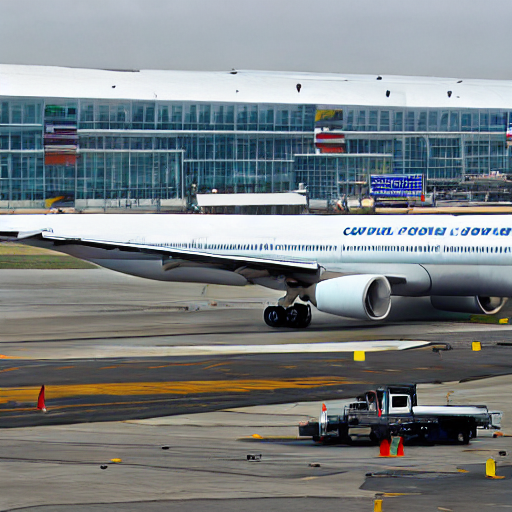

Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.INFO.20260101-054054.244644': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.INFO.20260101-054054.244644': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.INFO.20260101-054054.244644': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.INFO.20260101-054054.244644': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.INFO.20260101-054054.244644': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-f880906e-w-0.khang.log.INFO.20260101-054054.244644': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_lo

In [ ]:
from PIL import Image
import numpy as np

Image.fromarray((images[0] * 255.).astype(np.uint8))